<a href="https://colab.research.google.com/github/Smjfirna/Arsitektur-Compration/blob/main/GoogleNet%20final/Googlenet%20TL%20pytorch%20100.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import os
import cv2
import numpy as np
from tqdm import tqdm
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import confusion_matrix, classification_report
from torch.utils.data import Dataset, DataLoader
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import models, transforms
from PIL import Image
import copy
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf

In [2]:
# Download dataset dari Kaggle
from google.colab import files
files.upload()

!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

!kaggle datasets download -d smaranjitghose/corn-or-maize-leaf-disease-dataset
!unzip -q corn-or-maize-leaf-disease-dataset.zip -d /content

Saving kaggle.json to kaggle.json
Dataset URL: https://www.kaggle.com/datasets/smaranjitghose/corn-or-maize-leaf-disease-dataset
License(s): copyright-authors
 88% 142M/161M [00:00<00:00, 194MB/s]
100% 161M/161M [00:00<00:00, 196MB/s]


In [6]:
# Image size
IMAGE_SIZE = 224

# Custom dataset
class CustomDataset(Dataset):
    def __init__(self, image_paths, labels, transform=None):
        self.image_paths = image_paths
        self.labels = labels
        self.transform = transform

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, idx):
        img_path = self.image_paths[idx]
        image = cv2.imread(img_path)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        image = Image.fromarray(image)  # Convert to PIL Image
        if self.transform:
            image = self.transform(image)
        label = self.labels[idx]
        return image, label

# Function to make data
def make_data(label, DIR, img_list, label_list):
    for img in tqdm(os.listdir(DIR)):
        path = os.path.join(DIR, img)
        img_list.append(path)
        label_list.append(label)

# Dataset directory
dataset_dir = '/content/data'

# Lists to hold image paths and labels
image_paths = []
labels = []

# Load data
for i, class_name in enumerate(['Common_Rust', 'Healthy', 'Gray_Leaf_Spot', 'Blight']):
    class_dir = os.path.join(dataset_dir, class_name)
    make_data(i, class_dir, image_paths, labels)

# Encode labels
le = LabelEncoder()
labels = le.fit_transform(labels)

100%|██████████| 1146/1146 [00:00<00:00, 447715.39it/s]


In [7]:
# Split data into train and test sets
train_paths, test_paths, train_labels, test_labels = train_test_split(image_paths, labels, test_size=0.2, random_state=42)

# Data augmentation
data_transforms = {
    'train': transforms.Compose([
        transforms.Resize((224, 224)),
        transforms.RandomHorizontalFlip(),
        transforms.RandomRotation(20),
        transforms.ColorJitter(),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    'val': transforms.Compose([
        transforms.Resize((224, 224)),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
}

# Datasets and dataloaders
train_dataset = CustomDataset(train_paths, train_labels, transform=data_transforms['train'])
val_dataset = CustomDataset(test_paths, test_labels, transform=data_transforms['val'])

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True, num_workers=2)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False, num_workers=2)

In [10]:
# Model
model = models.googlenet(pretrained=True)

# Freeze all the parameters in the feature extractor layers
for param in model.parameters():
    param.requires_grad = False

# Replace the final layer
num_ftrs = model.fc.in_features
model.fc = nn.Linear(num_ftrs, len(le.classes_))  # Assuming len(le.classes_) gives the number of classes

# Move model to device
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
model = model.to(device)

# Loss function
criterion = nn.CrossEntropyLoss()

# Optimizer
optimizer = optim.Adam(model.parameters(), lr=0.0001)

# Training function
def train_model(model, criterion, optimizer, num_epochs=10):
    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0

    for epoch in range(num_epochs):
        print(f'Epoch {epoch + 1}/{num_epochs}')
        print('-' * 10)

        # Each epoch has a training and validation phase
        for phase in ['train', 'val']:
            if phase == 'train':
                model.train()  # Set model to training mode
            else:
                model.eval()   # Set model to evaluate mode

            running_loss = 0.0
            running_corrects = 0

            # Iterate over data.
            for inputs, labels in (train_loader if phase == 'train' else val_loader):
                inputs = inputs.to(device)
                labels = labels.to(device)

                # Zero the parameter gradients
                optimizer.zero_grad()

                # Forward
                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    _, preds = torch.max(outputs, 1)
                    loss = criterion(outputs, labels)

                    # Backward + optimize only if in training phase
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                # Statistics
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)

            epoch_loss = running_loss / len(train_loader.dataset if phase == 'train' else val_loader.dataset)
            epoch_acc = running_corrects.double() / len(train_loader.dataset if phase == 'train' else val_loader.dataset)

            print(f'{phase} Loss: {epoch_loss:.4f} Acc: {epoch_acc:.4f}')

            # Deep copy the model
            if phase == 'val' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())

        print()

    print('Best val Acc: {:4f}'.format(best_acc))

    # Load best model weights
    model.load_state_dict(best_model_wts)
    return model

# Train the model
model = train_model(model, criterion, optimizer, num_epochs=100)

Epoch 1/100
----------
train Loss: 1.1816 Acc: 0.5660
val Loss: 1.0293 Acc: 0.7589

Epoch 2/100
----------
train Loss: 0.9518 Acc: 0.7496
val Loss: 0.8547 Acc: 0.7936

Epoch 3/100
----------
train Loss: 0.8077 Acc: 0.7785
val Loss: 0.7481 Acc: 0.8103

Epoch 4/100
----------
train Loss: 0.7152 Acc: 0.7970
val Loss: 0.6627 Acc: 0.8258

Epoch 5/100
----------
train Loss: 0.6557 Acc: 0.8081
val Loss: 0.6199 Acc: 0.8258

Epoch 6/100
----------
train Loss: 0.5916 Acc: 0.8313
val Loss: 0.5697 Acc: 0.8413

Epoch 7/100
----------
train Loss: 0.5526 Acc: 0.8397
val Loss: 0.5328 Acc: 0.8544

Epoch 8/100
----------
train Loss: 0.5314 Acc: 0.8319
val Loss: 0.5098 Acc: 0.8508

Epoch 9/100
----------
train Loss: 0.5125 Acc: 0.8412
val Loss: 0.4790 Acc: 0.8687

Epoch 10/100
----------
train Loss: 0.4879 Acc: 0.8442
val Loss: 0.4636 Acc: 0.8723

Epoch 11/100
----------
train Loss: 0.4606 Acc: 0.8555
val Loss: 0.4464 Acc: 0.8723

Epoch 12/100
----------
train Loss: 0.4487 Acc: 0.8496
val Loss: 0.4264 Ac

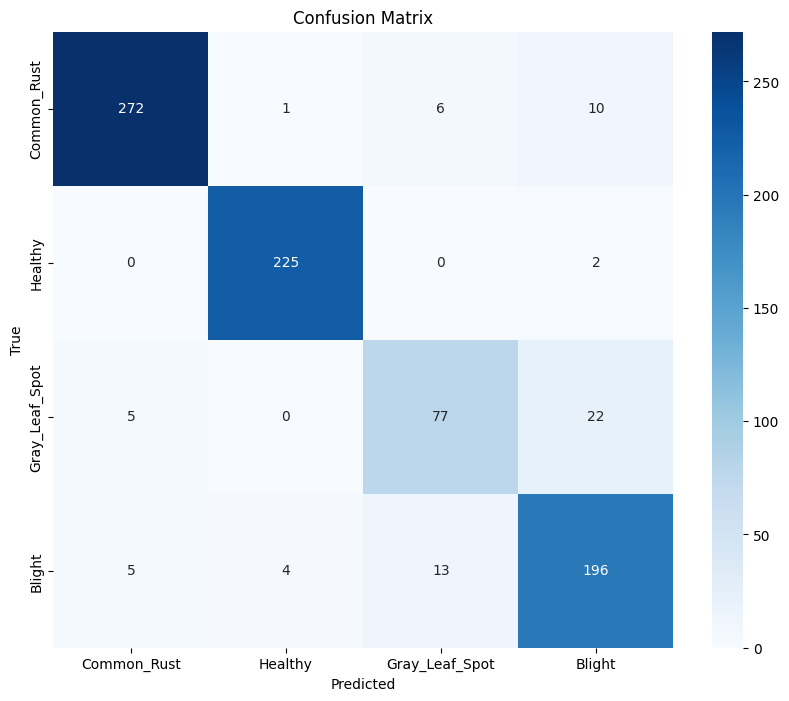


Classification Report:
              precision    recall  f1-score   support

           0       0.96      0.94      0.95       289
           1       0.98      0.99      0.98       227
           2       0.80      0.74      0.77       104
           3       0.85      0.90      0.88       218

    accuracy                           0.92       838
   macro avg       0.90      0.89      0.90       838
weighted avg       0.92      0.92      0.92       838



In [11]:
# Evaluate the model
model.eval()
all_preds = []
all_labels = []

with torch.no_grad():
    for inputs, labels in val_loader:
        inputs = inputs.to(device)
        labels = labels.to(device)
        outputs = model(inputs)
        _, preds = torch.max(outputs, 1)
        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

# Confusion matrix and classification report
conf_matrix = confusion_matrix(all_labels, all_preds)
class_names = [str(cls) for cls in le.classes_]
class_report = classification_report(all_labels, all_preds, target_names=class_names)

# Plot confusion matrix
plt.figure(figsize=(10, 8))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", xticklabels=['Common_Rust', 'Healthy', 'Gray_Leaf_Spot', 'Blight'], yticklabels=['Common_Rust', 'Healthy', 'Gray_Leaf_Spot', 'Blight'])
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("Confusion Matrix")
plt.show()

print("\nClassification Report:")
print(class_report)

In [12]:
torch.save(model.state_dict(), 'googlenetTL.pth')